# Prédiction d'Investissement - Prévision Récursive

Ce notebook regroupe toutes les cellules nécessaires pour exécuter les prévisions récursives avec Chronos-2 et Moirai-2.


## 1. Configuration et imports

**Note**: Nous ajoutons le répertoire parent au chemin Python pour importer nos modules personnalisés.


In [1]:
# Ajouter le répertoire racine du projet au chemin Python
import sys
from pathlib import Path

# Remonter au répertoire parent (racine du projet)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports standards
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Imports depuis nos scripts utilitaires
from ecb_forecast.compare import (
    Chronos2Runner,
    Moirai2Runner,
    merge_results,
    resolve_device,
    parse_torch_dtype
)
from ecb_forecast.datasets import (
    load_quarterly_dataset,
    compute_country_stats,
    prepare_country_context,
    prepare_moirai_inputs,
)
from scripts.save_recursive_to_template import save_to_template

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports réussis!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {resolve_device('auto')}")


✅ Imports réussis!
PyTorch version: 2.4.1
Device disponible: mps


## 2. Chargement des données


In [2]:
# Chemins des données (relatifs à la racine du projet)
DATA_DIR = project_root / "data" / "processed"
COMBINED_FILE = DATA_DIR / "investment_quarterly.csv"
RESULTS_DIR = project_root / "results"
RECURSIVE_TEMPLATE_FILE = RESULTS_DIR / "TeamXX_recursive_investment_predictions.xlsx"
excel_template_path = RECURSIVE_TEMPLATE_FILE

# Colonnes dans les données
ID_COLUMN = "country"
TIMESTAMP_COLUMN = "timestamp"
TARGET_COLUMN = "investment"

# Chargement du fichier combiné
df_full, dataset_summary = load_quarterly_dataset(
    COMBINED_FILE,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
)

print(f"📊 Données chargées: {dataset_summary.num_rows} observations")
print(f"Pays disponibles: {dataset_summary.series_ids}")
print(
    f"Période: {dataset_summary.start.date()} → {dataset_summary.end.date()}"
)
print(f"\nAperçu des données:")
df_full.head()


📊 Données chargées: 496 observations
Pays disponibles: ['DE', 'ES', 'FR', 'IT']
Période: 1995-01-01 → 2025-10-01

Aperçu des données:


,country,investment,investment_qoq,gdp,gdp_qoq,capacityprod_kg,capacityprod_ind,capacityutil_ind,capacityutil_kg,production_kg,...,orders_kg,exportorders_kg,expectedprod_kg,confidence_ind,orders_ind,exportorders_ind,expectedprod_ind,eei,timestamp,interest_rate
0,DE,31184.89,NaN,635687.43,NaN,11.2,13.9,84.349361,90.940051,NaN,...,-16.780977,-20.133333,22.283802,-1.890940,-16.496572,-27.814179,14.333097,95.266918,1995-01-01,7.432433
1,DE,31017.59,-0.537922,640777.12,0.797471,27.2,16.0,84.555137,85.447164,NaN,...,-15.364925,-18.300000,6.527275,-6.286330,-17.222819,-29.793289,5.311969,99.179924,1995-04-01,6.911238
2,DE,31647.75,2.011259,642071.09,0.201734,23.4,17.0,83.993828,83.946850,NaN,...,-17.168103,-15.400000,7.434031,-10.505105,-22.983488,-30.462502,1.416328,98.259968,1995-07-01,6.731235
3,DE,32071.58,1.330322,642329.89,0.040299,24.2,22.2,83.640921,86.561694,NaN,...,-16.479279,-18.266667,9.448246,-12.659780,-27.401496,-33.230317,1.011395,93.585268,1995-10-01,6.327264
4,DE,31569.64,-1.577438,637758.07,-0.714301,26.6,27.4,82.072253,83.743998,NaN,...,-27.405455,-21.900000,-6.392925,-20.115165,-36.576565,-37.828439,-6.917419,93.294153,1996-01-01,6.178932


In [3]:
# Afficher quelques statistiques par pays
print("📈 Statistiques par pays:\n")
country_stats = compute_country_stats(
    df_full,
    id_column=ID_COLUMN,
    target_column=TARGET_COLUMN,
)
for stat in country_stats:
    print(
        f"{stat.series_id}: {stat.observations} observations | Moyenne: {stat.mean:.0f} | "
        f"Std: {stat.std:.0f} | Coverage: {stat.coverage:.1%}"
    )


📈 Statistiques par pays:

DE: 124 observations | Moyenne: 48984 | Std: 9133 | Coverage: 98.4%
ES: 124 observations | Moyenne: 15987 | Std: 2956 | Coverage: 99.2%
FR: 124 observations | Moyenne: 27024 | Std: 3993 | Coverage: 99.2%
IT: 124 observations | Moyenne: 30747 | Std: 3697 | Coverage: 95.2%


## 2.5. Chargement et préparation du dataset enrichi

**Note**: Nous chargeons le fichier final_data.csv et sélectionnons les colonnes macro (de investment_DE_quarterly) ainsi que les features GDELT sélectionnées.


In [4]:
# Charger le fichier final_data.csv
FINAL_DATA_PATH = project_root / "data" / "new_dataset" / "final_data.csv"
df_final = pd.read_csv(FINAL_DATA_PATH)

# Définir les colonnes macro (présentes dans investment_DE_quarterly)
macro_columns = [
    'Country',
    'QuarterDate',
    'investment',
    'investment_qoq',
    'gdp',
    'gdp_qoq',
    'capacityprod_kg',
    'capacityprod_ind',
    'capacityutil_ind',
    'capacityutil_kg',
    'production_kg',
    'turnover_kg',
    'imports_xea_kg',
    'imports_ea_kg',
    'imports_kg',
    'exports_xea_kg',
    'exports_ea_kg',
    'exports_kg',
    'confidence_kg',
    'orders_kg',
    'exportorders_kg',
    'expectedprod_kg',
    'confidence_ind',
    'orders_ind',
    'exportorders_ind',
    'expectedprod_ind',
    'eei'
]

# Définir les features GDELT sélectionnées
gdelt_features = [
    # Polarity features (moving averages)
    'Polarity_EasyBuss_pol_ma2',
    'Polarity_Tech_pol_ma2',
    'Polarity_Ecology_pol_ma2',
    'Polarity_Macro_pol_ma2',
    'Polarity_Infra_pol_ma2',
    'Polarity_Tourism_pol_ma2',
    'Polarity_EasyBuss_pol_ma4',
    'Polarity_Tech_pol_ma4',
    'Polarity_Ecology_pol_ma4',
    'Polarity_Macro_pol_ma4',
    'Polarity_Infra_pol_ma4',
    'Polarity_Tourism_pol_ma4',
    # RowCount ratios (standardized)
    'RowCount_EasyBuss_ratio_rat_std',
    'RowCount_Tech_ratio_rat_std',
    'RowCount_Ecology_ratio_rat_std',
    'RowCount_Macro_ratio_rat_std',
    'RowCount_Infra_ratio_rat_std',
    'RowCount_Tourism_ratio_rat_std',
    # Negative scores (using base names as _neg_hpt versions don't exist)
    'Negativescore_Infra',
    'Negativescore_Tourism',
    # Uncertainty indices (using base names as _unc_std versions don't exist)
    'Uncertainty_EasyBuss',
    'Uncertainty_Tech',
    'Uncertainty_Macro',
    # Crime, strikes, and privatization indices
    'AttentionIndex3mMA_strikes',
    'SentimentIndex3mMA_crime',
    'AttentionIndex3mMA_crime',
    'SentimentIndex3mMA_privatization',
    'AttentionIndex3mMA_privatization'
]

# Combiner les listes de colonnes
selected_columns = macro_columns + gdelt_features

# Vérifier quelles colonnes existent dans le dataframe
available_columns = [col for col in selected_columns if col in df_final.columns]
missing_columns = [col for col in selected_columns if col not in df_final.columns]

print(f"📊 Dataset final_data.csv chargé: {len(df_final)} lignes, {len(df_final.columns)} colonnes au total")
print(f"\n✅ Colonnes disponibles: {len(available_columns)}/{len(selected_columns)}")

if missing_columns:
    print(f"\n⚠️ Colonnes manquantes ({len(missing_columns)}):")
    for col in missing_columns:
        print(f"  - {col}")

# Sélectionner les colonnes disponibles
df_enriched = df_final[available_columns].copy()

print(f"\n📈 Dataset enrichi créé: {len(df_enriched)} lignes × {len(df_enriched.columns)} colonnes")
print(f"\nAperçu des données enrichies:")
df_enriched.head()


📊 Dataset final_data.csv chargé: 496 lignes, 124 colonnes au total

✅ Colonnes disponibles: 55/55

📈 Dataset enrichi créé: 496 lignes × 55 colonnes

Aperçu des données enrichies:


,Country,QuarterDate,investment,investment_qoq,gdp,gdp_qoq,capacityprod_kg,capacityprod_ind,capacityutil_ind,capacityutil_kg,...,Negativescore_Infra,Negativescore_Tourism,Uncertainty_EasyBuss,Uncertainty_Tech,Uncertainty_Macro,AttentionIndex3mMA_strikes,SentimentIndex3mMA_crime,AttentionIndex3mMA_crime,SentimentIndex3mMA_privatization,AttentionIndex3mMA_privatization
0,DE,1995-01,31184.89,NaN,635687.43,NaN,11.2,13.9,84.349361,90.940051,...,4.416310,3.147657,4.515343,3.971039,4.225845,115.770489,1.001785,145.184085,-0.858559,228.957339
1,DE,1995-04,31017.59,-0.537922,640777.12,0.797471,27.2,16.0,84.555137,85.447164,...,4.418464,3.504668,4.343061,3.978390,3.988422,116.756017,0.664687,105.592755,-0.439100,133.710824
2,DE,1995-07,31647.75,2.011259,642071.09,0.201734,23.4,17.0,83.993828,83.946850,...,4.677746,3.627027,4.468265,4.023575,4.215920,88.962292,0.165068,97.783755,0.283986,188.369623
3,DE,1995-10,32071.58,1.330322,642329.89,0.040299,24.2,22.2,83.640921,86.561694,...,4.491904,3.250888,4.332861,3.968702,3.990618,90.286594,-0.214364,123.408279,0.281272,111.086759
4,DE,1996-01,31569.64,-1.577438,637758.07,-0.714301,26.6,27.4,82.072253,83.743998,...,4.920851,4.697692,4.347616,3.954052,4.046973,87.527962,-0.781003,110.675393,0.234911,72.072471


In [5]:
# Afficher des statistiques détaillées sur le dataset enrichi
print("📊 Informations détaillées sur le dataset enrichi:\n")
print(f"Shape: {df_enriched.shape}")
print(f"\nNombre de valeurs manquantes par colonne:")
missing_counts = df_enriched.isnull().sum()
missing_pct = (missing_counts / len(df_enriched) * 100).round(2)
missing_df = pd.DataFrame({
    'Colonne': missing_counts.index,
    'Valeurs manquantes': missing_counts.values,
    'Pourcentage': missing_pct.values
})
missing_df = missing_df[missing_df['Valeurs manquantes'] > 0].sort_values('Valeurs manquantes', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✅ Aucune valeur manquante!")

# Afficher les pays disponibles
if 'Country' in df_enriched.columns:
    print(f"\n🌍 Pays disponibles: {df_enriched['Country'].unique().tolist()}")
    print(f"Nombre d'observations par pays:")
    print(df_enriched['Country'].value_counts().sort_index())

# Afficher la période couverte
if 'QuarterDate' in df_enriched.columns:
    print(f"\n📅 Période couverte:")
    print(f"  Début: {df_enriched['QuarterDate'].min()}")
    print(f"  Fin: {df_enriched['QuarterDate'].max()}")


📊 Informations détaillées sur le dataset enrichi:

Shape: (496, 55)

Nombre de valeurs manquantes par colonne:
                         Colonne  Valeurs manquantes  Pourcentage
AttentionIndex3mMA_privatization                 324        65.32
           Negativescore_Tourism                 324        65.32
  RowCount_Ecology_ratio_rat_std                 324        65.32
    RowCount_Macro_ratio_rat_std                 324        65.32
    RowCount_Infra_ratio_rat_std                 324        65.32
  RowCount_Tourism_ratio_rat_std                 324        65.32
             Negativescore_Infra                 324        65.32
 RowCount_EasyBuss_ratio_rat_std                 324        65.32
     RowCount_Tech_ratio_rat_std                 324        65.32
            Uncertainty_EasyBuss                 324        65.32
                Uncertainty_Tech                 324        65.32
               Uncertainty_Macro                 324        65.32
      AttentionIndex3mMA_strike

In [6]:
# Optionnel: Sauvegarder le dataset enrichi
SAVE_ENRICHED = False  # Mettre à True pour sauvegarder

if SAVE_ENRICHED:
    output_path = project_root / "data" / "processed" / "enriched_dataset.csv"
    df_enriched.to_csv(output_path, index=False)
    print(f"✅ Dataset enrichi sauvegardé dans: {output_path}")
else:
    print("ℹ️ Dataset enrichi non sauvegardé (mettre SAVE_ENRICHED = True pour sauvegarder)")


ℹ️ Dataset enrichi non sauvegardé (mettre SAVE_ENRICHED = True pour sauvegarder)


## 3. Configuration des modèles


In [7]:
# ========== PARAMÈTRES À AJUSTER ==========

# Pays à prédire (choix: 'DE', 'ES', 'FR', 'IT')
TARGET_COUNTRY = "DE"

# Date de fin des données d'entraînement (début de la période de prévision)
CUTOFF_DATE = "2020-12-31"

# Horizon de prédiction (nombre de trimestres)
PREDICTION_LENGTH = 17

# Niveaux de quantiles pour les intervalles de confiance
QUANTILE_LEVELS = [0.1, 0.5, 0.9]

# Modèles à utiliser
CHRONOS_MODEL = "amazon/chronos-2"
MOIRAI_MODEL = "Salesforce/moirai-2.0-R-small"

# Paramètres de génération pour Moirai
MOIRAI_SAMPLES = 16
TEMPERATURE = 0.8
TOP_P = 0.9
TOP_K = 50

# Device et dtype
DEVICE = "auto"  # 'auto', 'cpu', 'cuda', or 'mps'
CHRONOS_DTYPE = "auto"  # 'auto', 'float32', 'float16', or 'bfloat16'
MOIRAI_DTYPE = "bfloat16"

print(f"🎯 Configuration:")
print(f"  Pays cible: {TARGET_COUNTRY}")
print(f"  Date de coupure: {CUTOFF_DATE}")
print(f"  Horizon: {PREDICTION_LENGTH} trimestres")
print(f"  Quantiles: {QUANTILE_LEVELS}")
print(f"  Device: {resolve_device(DEVICE)}")


🎯 Configuration:
  Pays cible: DE
  Date de coupure: 2020-12-31
  Horizon: 17 trimestres
  Quantiles: [0.1, 0.5, 0.9]
  Device: mps


## 4. Initialisation des modèles


In [8]:
print("🔄 Chargement du modèle Chronos-2...")

chronos_device = resolve_device(DEVICE)
chronos_dtype = parse_torch_dtype(CHRONOS_DTYPE)

chronos_runner = Chronos2Runner(
    model_name=CHRONOS_MODEL,
    device_map=chronos_device,
    dtype=chronos_dtype
)

print("✅ Modèle Chronos-2 chargé!")
print(f"   Device: {chronos_device}")
print(f"   Dtype: {chronos_dtype}")


🔄 Chargement du modèle Chronos-2...


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


✅ Modèle Chronos-2 chargé!
   Device: mps
   Dtype: auto


In [9]:
print("🔄 Chargement du modèle Moirai-2...")

moirai_device = resolve_device(DEVICE)
if moirai_device == "mps":
    print("⚠️  MPS détecté - utilisation de CPU pour Moirai-2 (meilleure compatibilité)")
    moirai_device = "cpu"

moirai_dtype = parse_torch_dtype(MOIRAI_DTYPE)

moirai_runner = Moirai2Runner(
    model_name=MOIRAI_MODEL,
    device_map=moirai_device,
    dtype=moirai_dtype
)

print("✅ Modèle Moirai-2 chargé!")
print(f"   Device: {moirai_device}")
print(f"   Dtype: {moirai_dtype}")


🔄 Chargement du modèle Moirai-2...
⚠️  MPS détecté - utilisation de CPU pour Moirai-2 (meilleure compatibilité)
✅ Modèle Moirai-2 chargé!
   Device: cpu
   Dtype: torch.bfloat16


---

## 📊 COMPARAISON: Données Macro vs Macro + GDELT

Cette section compare les performances du modèle **Chronos-2** avec deux configurations de données:
1. **Macro uniquement**: Colonnes macroéconomiques traditionnelles
2. **Macro + GDELT**: Colonnes macro + indicateurs GDELT (sentiment, attention, etc.)

L'objectif est d'évaluer si l'ajout d'indicateurs GDELT améliore la qualité des prévisions.


### 4.1. Configuration de la comparaison


In [10]:
# Configuration pour la comparaison
COMPARISON_COUNTRY = "DE"
COMPARISON_START_DATE = "2020-10-01"  # Premier cutoff pour la prévision récursive
COMPARISON_END_DATE = "2024-10-01"    # Dernier cutoff
COMPARISON_HORIZON = 4                # Nombre de trimestres à prévoir à chaque itération
COMPARISON_QUANTILES = [0.1, 0.5, 0.9]

print("🎯 Configuration de la comparaison Macro vs Macro+GDELT:")
print(f"  Pays: {COMPARISON_COUNTRY}")
print(f"  Modèle: Chronos-2 uniquement")
print(f"  Horizon par itération: {COMPARISON_HORIZON} trimestres")
print(f"  Période de prévision: {COMPARISON_START_DATE} → {COMPARISON_END_DATE}")
print(f"  Quantiles: {COMPARISON_QUANTILES}")


🎯 Configuration de la comparaison Macro vs Macro+GDELT:
  Pays: DE
  Modèle: Chronos-2 uniquement
  Horizon par itération: 4 trimestres
  Période de prévision: 2020-10-01 → 2024-10-01
  Quantiles: [0.1, 0.5, 0.9]


### 4.2. Préparation des deux datasets


In [11]:
# Préparer le dataset avec UNIQUEMENT les colonnes macro
df_macro_only = df_enriched[macro_columns].copy()

# Le dataset macro + GDELT est déjà disponible (df_enriched)
df_macro_gdelt = df_enriched.copy()

# Filtrer pour le pays ciblé et ajouter une colonne timestamp
for df in [df_macro_only, df_macro_gdelt]:
    df['timestamp'] = pd.to_datetime(df['QuarterDate'])
    df['country'] = df['Country']

# Filtrer pour le pays
df_macro_only_country = df_macro_only[df_macro_only['Country'] == COMPARISON_COUNTRY].copy()
df_macro_gdelt_country = df_macro_gdelt[df_macro_gdelt['Country'] == COMPARISON_COUNTRY].copy()

# Trier par date
df_macro_only_country = df_macro_only_country.sort_values('timestamp').reset_index(drop=True)
df_macro_gdelt_country = df_macro_gdelt_country.sort_values('timestamp').reset_index(drop=True)

print("📊 Datasets préparés:")
print(f"\n1️⃣ Macro uniquement:")
print(f"   - Observations: {len(df_macro_only_country)}")
print(f"   - Colonnes: {len(df_macro_only_country.columns)}")
print(f"   - Variables numériques: {df_macro_only_country.select_dtypes(include=[np.number]).shape[1]}")

print(f"\n2️⃣ Macro + GDELT:")
print(f"   - Observations: {len(df_macro_gdelt_country)}")
print(f"   - Colonnes: {len(df_macro_gdelt_country.columns)}")
print(f"   - Variables numériques: {df_macro_gdelt_country.select_dtypes(include=[np.number]).shape[1]}")

print(f"\n📅 Période couverte:")
print(f"   - Début: {df_macro_only_country['timestamp'].min().date()}")
print(f"   - Fin: {df_macro_only_country['timestamp'].max().date()}")


📊 Datasets préparés:

1️⃣ Macro uniquement:
   - Observations: 124
   - Colonnes: 29
   - Variables numériques: 25

2️⃣ Macro + GDELT:
   - Observations: 124
   - Colonnes: 57
   - Variables numériques: 53

📅 Période couverte:
   - Début: 1995-01-01
   - Fin: 2025-10-01


### 4.3. Fonction de prévision récursive pour la comparaison


In [12]:
def recursive_forecast_comparison(
    df,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    target_column="investment",
    timestamp_column="timestamp",
    id_column="country"
):
    """
    Perform recursive forecasting for comparison using Chronos-2.
    
    Args:
        df: DataFrame with identifier, timestamp, and target columns
        start_date: First cutoff date
        end_date: Last cutoff date
        horizon: Number of quarters to forecast at each iteration
        quantile_levels: Quantiles to predict
        target_column: Name of the target variable
        timestamp_column: Timestamp column name
        id_column: Column identifying the series
    
    Returns:
        DataFrame with all forecasts and metadata
    """
    results = []
    
    # Prepare dataframe
    working_df = df.copy()
    working_df[timestamp_column] = pd.to_datetime(working_df[timestamp_column])
    working_df = working_df.sort_values(timestamp_column).reset_index(drop=True)
    
    if id_column not in working_df.columns:
        working_df[id_column] = "series_1"
    
    active_series = str(working_df[id_column].iloc[0])
    working_df[id_column] = active_series
    
    # Convert dates
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)
    
    # Get forecast origins
    all_dates = sorted(working_df[timestamp_column].unique())
    forecast_origins = [ts for ts in all_dates if start_ts <= ts <= end_ts]
    
    print(f"🔄 Prévision récursive sur {len(forecast_origins)} points de coupure...")
    
    for idx, origin in enumerate(forecast_origins, 1):
        context_data = working_df[working_df[timestamp_column] <= origin].copy()
        
        if len(context_data) < 4:
            continue
        
        try:
            forecast_context = prepare_country_context(
                context_data,
                prediction_length=horizon,
                series_id=active_series,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            chronos_result = chronos_runner.run(
                context_df=forecast_context.dataframe,
                prediction_length=horizon,
                quantile_levels=quantile_levels,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column
            )
            
            forecast_df = chronos_result.df.copy()
            quantile_columns = {}
            for q in quantile_levels:
                col = f"chronos_p{int(round(q * 100)):02d}"
                if col in forecast_df.columns:
                    quantile_columns[q] = col
            
            median_col = quantile_columns.get(0.5)
            if median_col is None and 'chronos_p50' in forecast_df.columns:
                median_col = 'chronos_p50'
            if median_col is None and quantile_columns:
                closest = min(quantile_columns.keys(), key=lambda q: abs(q - 0.5))
                median_col = quantile_columns[closest]
            if median_col is None and 'chronos_mean' in forecast_df.columns:
                median_col = 'chronos_mean'
            
            for h, (_, row) in enumerate(forecast_df.iterrows(), 1):
                future_date = row[timestamp_column]
                result = {
                    'cutoff': origin,
                    'oos_date': future_date,
                    'horizon': h,
                    'y_pred': row[median_col] if median_col else np.nan
                }
                
                for q, col in quantile_columns.items():
                    result[f'quantile_{q}'] = row[col]
                
                true_val = working_df.loc[working_df[timestamp_column] == future_date, target_column]
                result['y_true'] = true_val.iloc[0] if not true_val.empty else np.nan
                
                results.append(result)
            
            if idx % 4 == 0:
                print(f"   Traité {idx}/{len(forecast_origins)} cutoffs...")
        except Exception as e:
            print(f"⚠️ Erreur au cutoff {origin}: {e}")
            continue
    
    print(f"✅ Prévision terminée: {len(results)} prévisions générées")
    
    return pd.DataFrame(results)

print("✅ Fonction de prévision récursive définie")


✅ Fonction de prévision récursive définie


### 4.4. Exécution des prévisions - Dataset Macro uniquement


In [13]:
print("=" * 60)
print("1️⃣ PRÉVISIONS AVEC DONNÉES MACRO UNIQUEMENT")
print("=" * 60)

results_macro = recursive_forecast_comparison(
    df=df_macro_only_country,
    start_date=COMPARISON_START_DATE,
    end_date=COMPARISON_END_DATE,
    horizon=COMPARISON_HORIZON,
    quantile_levels=COMPARISON_QUANTILES,
    target_column='investment'
)

print(f"\n📊 Résultats Macro uniquement:")
print(f"   - Nombre de prévisions: {len(results_macro)}")
print(f"   - Prévisions avec valeur réelle: {results_macro['y_true'].notna().sum()}")
print(f"\nAperçu:")
print(results_macro.head())


1️⃣ PRÉVISIONS AVEC DONNÉES MACRO UNIQUEMENT
🔄 Prévision récursive sur 17 points de coupure...


   Traité 4/17 cutoffs...
   Traité 8/17 cutoffs...
   Traité 12/17 cutoffs...
   Traité 16/17 cutoffs...
✅ Prévision terminée: 68 prévisions générées

📊 Résultats Macro uniquement:
   - Nombre de prévisions: 68
   - Prévisions avec valeur réelle: 65

Aperçu:
      cutoff   oos_date  horizon        y_pred  quantile_0.1  quantile_0.5  \
0 2020-10-01 2021-01-01        1  58550.984375  55514.625000  58550.984375   
1 2020-10-01 2021-04-01        2  59444.921875  55361.632812  59444.921875   
2 2020-10-01 2021-07-01        3  60117.648438  55522.453125  60117.648438   
3 2020-10-01 2021-10-01        4  60492.617188  55052.000000  60492.617188   
4 2021-01-01 2021-04-01        1  57893.164062  54872.738281  57893.164062   

   quantile_0.9    y_true  
0  61064.148438  57443.01  
1  62682.234375  58786.93  
2  64048.652344  56216.19  
3  65028.035156  57219.96  
4  60243.140625  58786.93  


### 4.5. Exécution des prévisions - Dataset Macro + GDELT


In [14]:
print("=" * 60)
print("2️⃣ PRÉVISIONS AVEC DONNÉES MACRO + GDELT")
print("=" * 60)

results_macro_gdelt = recursive_forecast_comparison(
    df=df_macro_gdelt_country,
    start_date=COMPARISON_START_DATE,
    end_date=COMPARISON_END_DATE,
    horizon=COMPARISON_HORIZON,
    quantile_levels=COMPARISON_QUANTILES,
    target_column='investment'
)

print(f"\n📊 Résultats Macro + GDELT:")
print(f"   - Nombre de prévisions: {len(results_macro_gdelt)}")
print(f"   - Prévisions avec valeur réelle: {results_macro_gdelt['y_true'].notna().sum()}")
print(f"\nAperçu:")
print(results_macro_gdelt.head())


2️⃣ PRÉVISIONS AVEC DONNÉES MACRO + GDELT
🔄 Prévision récursive sur 17 points de coupure...
   Traité 4/17 cutoffs...
   Traité 8/17 cutoffs...
   Traité 12/17 cutoffs...
   Traité 16/17 cutoffs...
✅ Prévision terminée: 68 prévisions générées

📊 Résultats Macro + GDELT:
   - Nombre de prévisions: 68
   - Prévisions avec valeur réelle: 65

Aperçu:
      cutoff   oos_date  horizon        y_pred  quantile_0.1  quantile_0.5  \
0 2020-10-01 2021-01-01        1  58550.984375  55514.625000  58550.984375   
1 2020-10-01 2021-04-01        2  59444.921875  55361.632812  59444.921875   
2 2020-10-01 2021-07-01        3  60117.648438  55522.453125  60117.648438   
3 2020-10-01 2021-10-01        4  60492.617188  55052.000000  60492.617188   
4 2021-01-01 2021-04-01        1  57893.164062  54872.738281  57893.164062   

   quantile_0.9    y_true  
0  61064.148438  57443.01  
1  62682.234375  58786.93  
2  64048.652344  56216.19  
3  65028.035156  57219.96  
4  60243.140625  58786.93  


### 4.6. Calcul et comparaison des métriques


In [15]:
def compute_metrics(results_df):
    """Compute forecast metrics (MAE, RMSE, MAPE) by horizon."""
    metrics = []
    
    # Filter out rows without true values
    valid_df = results_df[results_df['y_true'].notna()].copy()
    
    if len(valid_df) == 0:
        print("⚠️ Aucune valeur réelle disponible pour calculer les métriques")
        return pd.DataFrame()
    
    # Compute errors
    valid_df['error'] = valid_df['y_pred'] - valid_df['y_true']
    valid_df['abs_error'] = np.abs(valid_df['error'])
    valid_df['sq_error'] = valid_df['error'] ** 2
    valid_df['abs_pct_error'] = np.abs(valid_df['error'] / valid_df['y_true']) * 100
    
    # Overall metrics
    overall = {
        'horizon': 'All',
        'n_forecasts': len(valid_df),
        'MAE': valid_df['abs_error'].mean(),
        'RMSE': np.sqrt(valid_df['sq_error'].mean()),
        'MAPE': valid_df['abs_pct_error'].mean()
    }
    metrics.append(overall)
    
    # Metrics by horizon
    for h in sorted(valid_df['horizon'].unique()):
        h_df = valid_df[valid_df['horizon'] == h]
        horizon_metrics = {
            'horizon': f'{h}Q',
            'n_forecasts': len(h_df),
            'MAE': h_df['abs_error'].mean(),
            'RMSE': np.sqrt(h_df['sq_error'].mean()),
            'MAPE': h_df['abs_pct_error'].mean()
        }
        metrics.append(horizon_metrics)
    
    return pd.DataFrame(metrics)

# Compute metrics for both datasets
print("📊 CALCUL DES MÉTRIQUES\n")
print("=" * 60)

metrics_macro = compute_metrics(results_macro)
print("\n1️⃣ Métriques - Macro uniquement:")
print(metrics_macro.to_string(index=False))

print("\n" + "=" * 60)

metrics_macro_gdelt = compute_metrics(results_macro_gdelt)
print("\n2️⃣ Métriques - Macro + GDELT:")
print(metrics_macro_gdelt.to_string(index=False))


📊 CALCUL DES MÉTRIQUES


1️⃣ Métriques - Macro uniquement:
horizon  n_forecasts         MAE        RMSE     MAPE
    All           65 2364.770834 2902.086487 4.062792
     1Q           17 1245.091976 1480.417743 2.123788
     2Q           17 1989.898869 2245.356952 3.409787
     3Q           16 2910.153359 3279.652261 5.003006
     4Q           15 3476.853740 4101.816574 5.997509


2️⃣ Métriques - Macro + GDELT:
horizon  n_forecasts         MAE        RMSE     MAPE
    All           65 2364.770834 2902.086487 4.062792
     1Q           17 1245.091976 1480.417743 2.123788
     2Q           17 1989.898869 2245.356952 3.409787
     3Q           16 2910.153359 3279.652261 5.003006
     4Q           15 3476.853740 4101.816574 5.997509


In [16]:
# Create comparison table
print("\n" + "=" * 80)
print("📊 TABLEAU COMPARATIF DES PERFORMANCES")
print("=" * 80)

comparison_data = []

for horizon in ['All', '1Q', '2Q', '3Q', '4Q']:
    # Get metrics for this horizon
    macro_row = metrics_macro[metrics_macro['horizon'] == horizon]
    gdelt_row = metrics_macro_gdelt[metrics_macro_gdelt['horizon'] == horizon]
    
    if len(macro_row) == 0 or len(gdelt_row) == 0:
        continue
    
    mae_macro = macro_row['MAE'].values[0]
    mae_gdelt = gdelt_row['MAE'].values[0]
    mae_improvement = ((mae_macro - mae_gdelt) / mae_macro) * 100
    
    rmse_macro = macro_row['RMSE'].values[0]
    rmse_gdelt = gdelt_row['RMSE'].values[0]
    rmse_improvement = ((rmse_macro - rmse_gdelt) / rmse_macro) * 100
    
    mape_macro = macro_row['MAPE'].values[0]
    mape_gdelt = gdelt_row['MAPE'].values[0]
    mape_improvement = ((mape_macro - mape_gdelt) / mape_macro) * 100
    
    comparison_data.append({
        'Horizon': horizon,
        'MAE_Macro': mae_macro,
        'MAE_GDELT': mae_gdelt,
        'MAE_Δ%': mae_improvement,
        'RMSE_Macro': rmse_macro,
        'RMSE_GDELT': rmse_gdelt,
        'RMSE_Δ%': rmse_improvement,
        'MAPE_Macro': mape_macro,
        'MAPE_GDELT': mape_gdelt,
        'MAPE_Δ%': mape_improvement
    })

comparison_df = pd.DataFrame(comparison_data)

# Display with formatting
print("\n")
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

print("\n" + "=" * 80)
print("💡 Interprétation:")
print("   - Δ% positif = amélioration avec GDELT (erreur réduite)")
print("   - Δ% négatif = dégradation avec GDELT (erreur augmentée)")
print("=" * 80)



📊 TABLEAU COMPARATIF DES PERFORMANCES


Horizon  MAE_Macro  MAE_GDELT  MAE_Δ%  RMSE_Macro  RMSE_GDELT  RMSE_Δ%  MAPE_Macro  MAPE_GDELT  MAPE_Δ%
    All    2364.77    2364.77    0.00     2902.09     2902.09     0.00        4.06        4.06     0.00
     1Q    1245.09    1245.09    0.00     1480.42     1480.42     0.00        2.12        2.12     0.00
     2Q    1989.90    1989.90    0.00     2245.36     2245.36     0.00        3.41        3.41     0.00
     3Q    2910.15    2910.15    0.00     3279.65     3279.65     0.00        5.00        5.00     0.00
     4Q    3476.85    3476.85    0.00     4101.82     4101.82     0.00        6.00        6.00     0.00

💡 Interprétation:
   - Δ% positif = amélioration avec GDELT (erreur réduite)
   - Δ% négatif = dégradation avec GDELT (erreur augmentée)


### 4.7. Visualisations comparatives


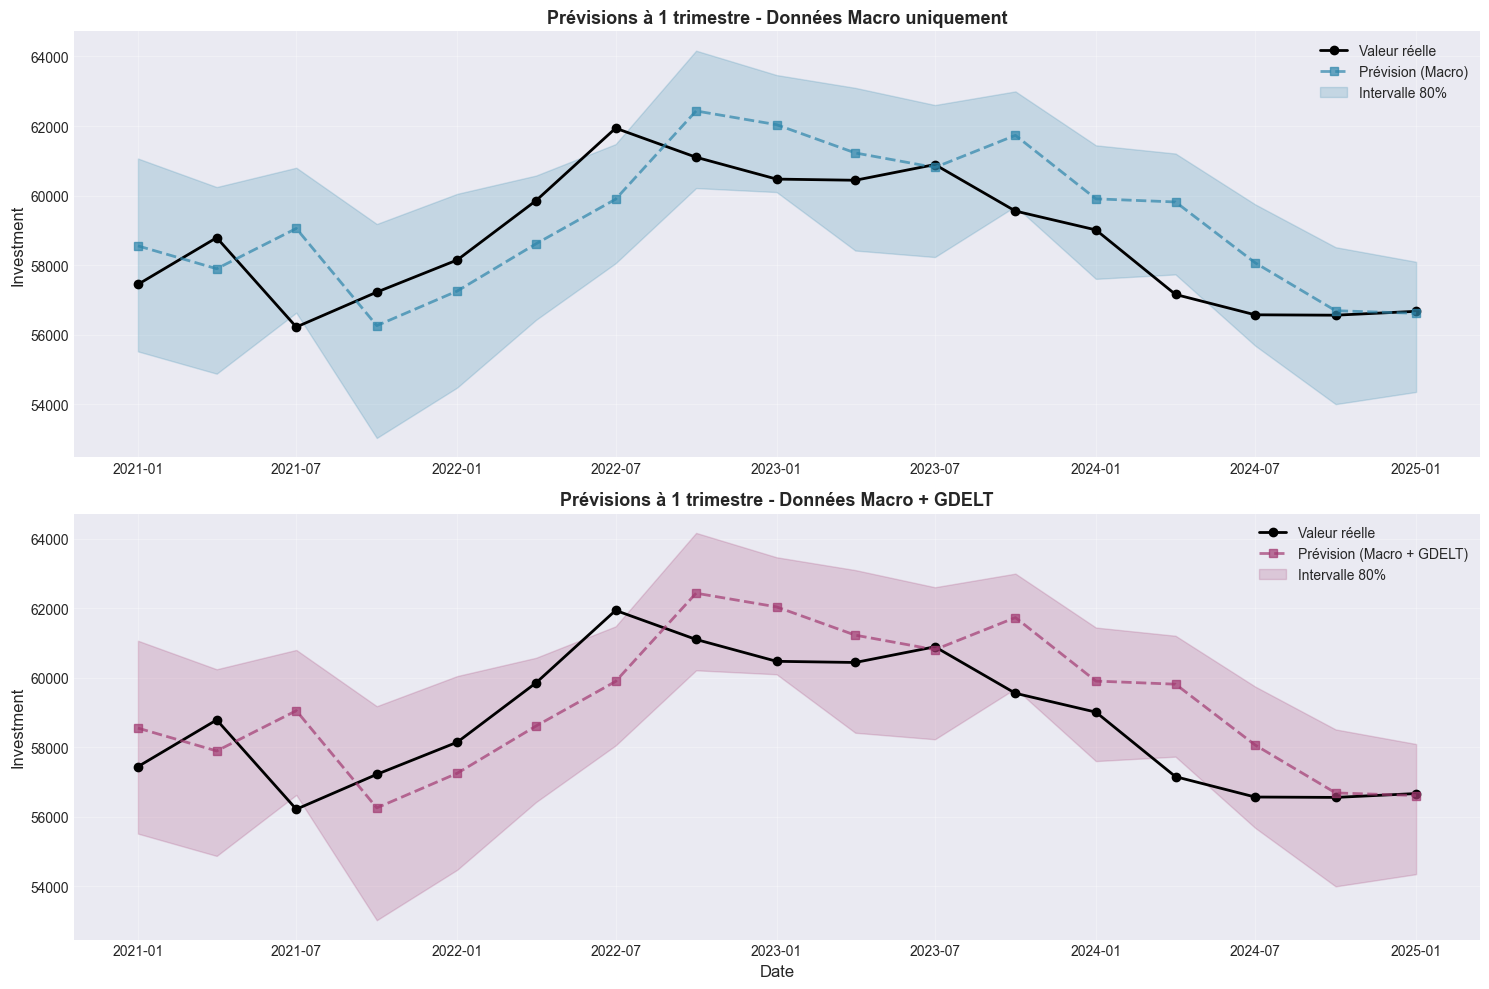


📊 Statistiques pour les prévisions à 1 trimestre:

Macro uniquement:
  - MAE: 1245.09
  - RMSE: 1480.42

Macro + GDELT:
  - MAE: 1245.09
  - RMSE: 1480.42


In [17]:
# Visualisation 3: Prévisions vs valeurs réelles pour horizon 1Q
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Filter for 1-quarter ahead predictions with true values
macro_1q = results_macro[(results_macro['horizon'] == 1) & (results_macro['y_true'].notna())].copy()
gdelt_1q = results_macro_gdelt[(results_macro_gdelt['horizon'] == 1) & (results_macro_gdelt['y_true'].notna())].copy()

# Sort by date
macro_1q = macro_1q.sort_values('oos_date')
gdelt_1q = gdelt_1q.sort_values('oos_date')

# Plot 1: Macro only
ax1 = axes[0]
ax1.plot(macro_1q['oos_date'], macro_1q['y_true'], 'o-', label='Valeur réelle', 
         color='black', linewidth=2, markersize=6)
ax1.plot(macro_1q['oos_date'], macro_1q['y_pred'], 's--', label='Prévision (Macro)', 
         color='#2E86AB', linewidth=2, markersize=6, alpha=0.7)
ax1.fill_between(macro_1q['oos_date'], 
                  macro_1q['quantile_0.1'], 
                  macro_1q['quantile_0.9'],
                  alpha=0.2, color='#2E86AB', label='Intervalle 80%')
ax1.set_ylabel('Investment', fontsize=12)
ax1.set_title('Prévisions à 1 trimestre - Données Macro uniquement', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Macro + GDELT
ax2 = axes[1]
ax2.plot(gdelt_1q['oos_date'], gdelt_1q['y_true'], 'o-', label='Valeur réelle', 
         color='black', linewidth=2, markersize=6)
ax2.plot(gdelt_1q['oos_date'], gdelt_1q['y_pred'], 's--', label='Prévision (Macro + GDELT)', 
         color='#A23B72', linewidth=2, markersize=6, alpha=0.7)
ax2.fill_between(gdelt_1q['oos_date'], 
                  gdelt_1q['quantile_0.1'], 
                  gdelt_1q['quantile_0.9'],
                  alpha=0.2, color='#A23B72', label='Intervalle 80%')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Investment', fontsize=12)
ax2.set_title('Prévisions à 1 trimestre - Données Macro + GDELT', fontsize=13, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 Statistiques pour les prévisions à 1 trimestre:")
print(f"\nMacro uniquement:")
print(f"  - MAE: {np.abs(macro_1q['y_pred'] - macro_1q['y_true']).mean():.2f}")
print(f"  - RMSE: {np.sqrt(((macro_1q['y_pred'] - macro_1q['y_true'])**2).mean()):.2f}")

print(f"\nMacro + GDELT:")
print(f"  - MAE: {np.abs(gdelt_1q['y_pred'] - gdelt_1q['y_true']).mean():.2f}")
print(f"  - RMSE: {np.sqrt(((gdelt_1q['y_pred'] - gdelt_1q['y_true'])**2).mean()):.2f}")


---

## 🔄 RECURSIVE FORECASTING APPROACH

This section implements a **recursive forecasting** methodology where:
- For each quarter, we forecast the next 4 quarters ahead
- Each forecast uses all historical data available up to that point
- This creates a rolling forecast window of 4 quarters


In [18]:
## Configuration pour la prévision récursive

# Paramètres
RECURSIVE_HORIZON = 4  # Nombre de trimestres à prévoir à chaque itération
RECURSIVE_COUNTRY = "DE"  # Pays à analyser
RECURSIVE_START_DATE = "2020-10-01"  # Date de début des prévisions (premier point de départ)
RECURSIVE_END_DATE = "2025-01-01"  # Date de fin des prévisions

print(f"🎯 Configuration de la prévision récursive:")
print(f"  Pays: {RECURSIVE_COUNTRY}")
print(f"  Horizon par itération: {RECURSIVE_HORIZON} trimestres")
print(f"  Période de prévision: {RECURSIVE_START_DATE} → {RECURSIVE_END_DATE}")
print(f"  Quantiles: {QUANTILE_LEVELS}")


🎯 Configuration de la prévision récursive:
  Pays: DE
  Horizon par itération: 4 trimestres
  Période de prévision: 2020-10-01 → 2025-01-01
  Quantiles: [0.1, 0.5, 0.9]


In [19]:
def recursive_forecast_chronos(
    full_df,
    country,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="country",
    timestamp_column="timestamp",
    target_column="investment"
):
    """
    Perform recursive forecasting with Chronos-2.
    
    For each quarter from start_date to end_date:
    - Use all historical data up to that quarter
    - Forecast the next 'horizon' quarters
    - Store the forecast
    
    Returns a DataFrame with all forecasts and their metadata.
    """
    results = []
    
    # Convert dates
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)
    
    # Filter for the country
    country_df = full_df[full_df[id_column] == country].copy()
    country_df = country_df.sort_values(timestamp_column).reset_index(drop=True)
    
    # Get all unique timestamps
    all_timestamps = sorted(country_df[timestamp_column].unique())
    
    # Find forecast origin points (quarters where we start forecasting from)
    forecast_origins = [ts for ts in all_timestamps if start_ts <= ts <= end_ts]
    
    print(f"🔄 Performing recursive forecasting for {country}")
    print(f"  Number of forecast origins: {len(forecast_origins)}")
    print(f"  Horizon per origin: {horizon} quarters")
    
    for idx, origin_date in enumerate(forecast_origins):
        # Get all data up to (and including) the origin date
        context_data = country_df[country_df[timestamp_column] <= origin_date].copy()
        
        if len(context_data) < 4:  # Need at least some history
            continue
        
        # Prepare context
        try:
            forecast_context = prepare_country_context(
                context_data,
                prediction_length=horizon,
                series_id=country,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            # Make prediction with Chronos
            chronos_result = chronos_runner.run(
                context_df=forecast_context.dataframe,
                prediction_length=horizon,
                quantile_levels=quantile_levels,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column
            )
            
            # Store results with metadata
            forecast_df = chronos_result.df.copy()
            forecast_df['origin_date'] = origin_date
            forecast_df['horizon_step'] = range(1, horizon + 1)
            forecast_df['model'] = 'Chronos-2'
            
            results.append(forecast_df)
            
            if (idx + 1) % 5 == 0:
                print(f"  Completed {idx + 1}/{len(forecast_origins)} forecast origins...")
                
        except Exception as e:
            print(f"  Warning: Failed for origin {origin_date}: {e}")
            continue
    
    if not results:
        raise ValueError("No forecasts were generated")
    
    # Combine all results
    all_forecasts = pd.concat(results, ignore_index=True)
    print(f"✅ Completed {len(forecast_origins)} recursive forecasts")
    
    return all_forecasts


def recursive_forecast_moirai(
    full_df,
    country,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="country",
    timestamp_column="timestamp",
    target_column="investment"
):
    """
    Perform recursive forecasting with Moirai-2.
    
    For each quarter from start_date to end_date:
    - Use all historical data up to that quarter
    - Forecast the next 'horizon' quarters
    - Store the forecast
    
    Returns a DataFrame with all forecasts and their metadata.
    """
    results = []
    
    # Convert dates
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)
    
    # Filter for the country
    country_df = full_df[full_df[id_column] == country].copy()
    country_df = country_df.sort_values(timestamp_column).reset_index(drop=True)
    
    # Get all unique timestamps
    all_timestamps = sorted(country_df[timestamp_column].unique())
    
    # Find forecast origin points
    forecast_origins = [ts for ts in all_timestamps if start_ts <= ts <= end_ts]
    
    print(f"🔄 Performing recursive forecasting for {country} with Moirai-2")
    print(f"  Number of forecast origins: {len(forecast_origins)}")
    print(f"  Horizon per origin: {horizon} quarters")
    
    for idx, origin_date in enumerate(forecast_origins):
        # Get all data up to (and including) the origin date
        context_data = country_df[country_df[timestamp_column] <= origin_date].copy()
        
        if len(context_data) < 4:
            continue
        
        try:
            # Prepare context
            forecast_context = prepare_country_context(
                context_data,
                prediction_length=horizon,
                series_id=country,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            # Prepare Moirai inputs
            context_values, start_timestamp, freq = prepare_moirai_inputs(
                forecast_context.dataframe,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            # Make prediction with Moirai
            moirai_result = moirai_runner.run(
                values=context_values,
                prediction_length=horizon,
                quantile_levels=quantile_levels,
                forecast_index=forecast_context.forecast_index,
                start_timestamp=start_timestamp,
                freq=freq
            )
            
            # Store results with metadata
            forecast_df = moirai_result.df.copy()
            forecast_df['origin_date'] = origin_date
            forecast_df['horizon_step'] = range(1, horizon + 1)
            forecast_df['model'] = 'Moirai-2'
            
            results.append(forecast_df)
            
            if (idx + 1) % 5 == 0:
                print(f"  Completed {idx + 1}/{len(forecast_origins)} forecast origins...")
                
        except Exception as e:
            print(f"  Warning: Failed for origin {origin_date}: {e}")
            continue
    
    if not results:
        raise ValueError("No forecasts were generated")
    
    # Combine all results
    all_forecasts = pd.concat(results, ignore_index=True)
    print(f"✅ Completed {len(forecast_origins)} recursive forecasts")
    
    return all_forecasts

print("✅ Recursive forecasting functions defined")


✅ Recursive forecasting functions defined


In [20]:
## Exécution de la prévision récursive avec Chronos-2

recursive_chronos_forecasts = recursive_forecast_chronos(
    full_df=df_full,
    country=RECURSIVE_COUNTRY,
    start_date=RECURSIVE_START_DATE,
    end_date=RECURSIVE_END_DATE,
    horizon=RECURSIVE_HORIZON,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN
)

print(f"\n📊 Aperçu des prévisions récursives Chronos-2:")
print(f"  Total de prévisions: {len(recursive_chronos_forecasts)}")
print(f"  Colonnes: {list(recursive_chronos_forecasts.columns)}")
print(f"\nPremières lignes:")
recursive_chronos_forecasts.head(12)


🔄 Performing recursive forecasting for DE
  Number of forecast origins: 18
  Horizon per origin: 4 quarters
  Completed 5/18 forecast origins...
  Completed 10/18 forecast origins...
  Completed 15/18 forecast origins...
✅ Completed 18 recursive forecasts

📊 Aperçu des prévisions récursives Chronos-2:
  Total de prévisions: 72
  Colonnes: ['timestamp', 'chronos_p10', 'chronos_p50', 'chronos_p90', 'origin_date', 'horizon_step', 'model']

Premières lignes:


,timestamp,chronos_p10,chronos_p50,chronos_p90,origin_date,horizon_step,model
0,2021-01-01,55514.625000,58550.984375,61064.148438,2020-10-01,1,Chronos-2
1,2021-04-01,55361.632812,59444.921875,62682.234375,2020-10-01,2,Chronos-2
2,2021-07-01,55522.453125,60117.648438,64048.652344,2020-10-01,3,Chronos-2
3,2021-10-01,55052.000000,60492.617188,65028.035156,2020-10-01,4,Chronos-2
4,2021-04-01,54872.738281,57893.164062,60243.140625,2021-01-01,1,Chronos-2
5,2021-07-01,53782.917969,58405.285156,61923.125000,2021-01-01,2,Chronos-2
6,2021-10-01,53017.929688,58780.742188,63389.031250,2021-01-01,3,Chronos-2
7,2022-01-01,52265.843750,59083.386719,64703.296875,2021-01-01,4,Chronos-2
8,2021-07-01,56629.007812,59052.148438,60799.355469,2021-04-01,1,Chronos-2
9,2021-10-01,55934.285156,59387.980469,61942.132812,2021-04-01,2,Chronos-2


In [21]:
## Exécution de la prévision récursive avec Moirai-2

recursive_moirai_forecasts = recursive_forecast_moirai(
    full_df=df_full,
    country=RECURSIVE_COUNTRY,
    start_date=RECURSIVE_START_DATE,
    end_date=RECURSIVE_END_DATE,
    horizon=RECURSIVE_HORIZON,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN
)

print(f"\n📊 Aperçu des prévisions récursives Moirai-2:")
print(f"  Total de prévisions: {len(recursive_moirai_forecasts)}")
print(f"  Colonnes: {list(recursive_moirai_forecasts.columns)}")
print(f"\nPremières lignes:")
recursive_moirai_forecasts.head(12)


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data;

🔄 Performing recursive forecasting for DE with Moirai-2
  Number of forecast origins: 18
  Horizon per origin: 4 quarters
  Completed 5/18 forecast origins...
  Completed 10/18 forecast origins...
  Completed 15/18 forecast origins...
✅ Completed 18 recursive forecasts

📊 Aperçu des prévisions récursives Moirai-2:
  Total de prévisions: 72
  Colonnes: ['timestamp', 'moirai_p10', 'moirai_p50', 'moirai_p90', 'moirai_mean', 'origin_date', 'horizon_step', 'model']

Premières lignes:


,timestamp,moirai_p10,moirai_p50,moirai_p90,moirai_mean,origin_date,horizon_step,model
0,2021-01-01,53215.886719,57534.367188,61504.871094,57534.367188,2020-10-01,1,Moirai-2
1,2021-04-01,51428.304688,57400.113281,62532.062500,57400.113281,2020-10-01,2,Moirai-2
2,2021-07-01,50014.484375,57129.488281,62919.664062,57129.488281,2020-10-01,3,Moirai-2
3,2021-10-01,49307.007812,57231.507812,63496.878906,57231.507812,2020-10-01,4,Moirai-2
4,2021-04-01,53338.000000,57168.593750,60769.457031,57168.593750,2021-01-01,1,Moirai-2
5,2021-07-01,51737.867188,57048.890625,61927.937500,57048.890625,2021-01-01,2,Moirai-2
6,2021-10-01,50342.968750,56771.617188,62447.214844,56771.617188,2021-01-01,3,Moirai-2
7,2022-01-01,49598.648438,56858.730469,63030.058594,56858.730469,2021-01-01,4,Moirai-2
8,2021-07-01,55351.078125,58608.015625,61507.480469,58608.015625,2021-04-01,1,Moirai-2
9,2021-10-01,54002.007812,58489.281250,62540.812500,58489.281250,2021-04-01,2,Moirai-2


In [22]:
## Ajout des valeurs réelles (Ground Truth) aux prévisions récursives

def add_ground_truth_to_recursive(forecasts_df, actual_df, country, 
                                   timestamp_col='timestamp', 
                                   target_col='investment',
                                   id_col='country'):
    """Add actual values to the recursive forecast dataframe."""
    # Filter actual data for the country
    actual_country = actual_df[actual_df[id_col] == country].copy()
    actual_dict = dict(zip(actual_country[timestamp_col], actual_country[target_col]))
    
    # Add actual values based on the timestamp (not origin_date)
    forecasts_df['actual'] = forecasts_df[timestamp_col].map(actual_dict)
    
    return forecasts_df

# Add ground truth to both models' forecasts
recursive_chronos_forecasts = add_ground_truth_to_recursive(
    recursive_chronos_forecasts, 
    df_full, 
    RECURSIVE_COUNTRY,
    TIMESTAMP_COLUMN,
    TARGET_COLUMN,
    ID_COLUMN
)

recursive_moirai_forecasts = add_ground_truth_to_recursive(
    recursive_moirai_forecasts, 
    df_full, 
    RECURSIVE_COUNTRY,
    TIMESTAMP_COLUMN,
    TARGET_COLUMN,
    ID_COLUMN
)

print("✅ Ground truth values added to recursive forecasts")
print(f"\nChronos-2: {recursive_chronos_forecasts['actual'].notna().sum()} forecasts with actual values")
print(f"Moirai-2: {recursive_moirai_forecasts['actual'].notna().sum()} forecasts with actual values")


✅ Ground truth values added to recursive forecasts

Chronos-2: 66 forecasts with actual values
Moirai-2: 66 forecasts with actual values


## 5. Recursive Forecasting Function

We'll use a simplified function that works with both base and fine-tuned models.


In [23]:
## 5. Évaluation des performances

def calculate_recursive_metrics(forecasts_df, model_name='Model'):
    """Calculate forecast accuracy metrics by horizon step."""
    
    # Get the median prediction column name
    median_col = [col for col in forecasts_df.columns if 'p50' in col.lower()][0]
    
    # Filter rows with actual values
    with_actual = forecasts_df[forecasts_df['actual'].notna()].copy()
    
    if len(with_actual) == 0:
        print(f"⚠️ No actual values available for {model_name}")
        return None
    
    # Calculate errors
    with_actual['error'] = with_actual[median_col] - with_actual['actual']
    with_actual['abs_error'] = np.abs(with_actual['error'])
    with_actual['squared_error'] = with_actual['error'] ** 2
    with_actual['pct_error'] = np.abs(with_actual['error'] / with_actual['actual']) * 100
    
    # Overall metrics
    overall_metrics = {
        'MAE': with_actual['abs_error'].mean(),
        'RMSE': np.sqrt(with_actual['squared_error'].mean()),
        'MAPE': with_actual['pct_error'].mean(),
        'Mean Error': with_actual['error'].mean(),
        'Std Error': with_actual['error'].std(),
        'N': len(with_actual)
    }
    
    # Metrics by horizon step
    horizon_metrics = []
    for horizon in sorted(with_actual['horizon_step'].unique()):
        horizon_data = with_actual[with_actual['horizon_step'] == horizon]
        horizon_metrics.append({
            'Horizon': f'{horizon}Q ahead',
            'N': len(horizon_data),
            'MAE': horizon_data['abs_error'].mean(),
            'RMSE': np.sqrt(horizon_data['squared_error'].mean()),
            'MAPE': horizon_data['pct_error'].mean(),
            'Mean Error': horizon_data['error'].mean(),
        })
    
    horizon_df = pd.DataFrame(horizon_metrics)
    
    return overall_metrics, horizon_df, with_actual

# Calculate metrics for both models
print("=" * 80)
print("📊 MÉTRIQUES DE PERFORMANCE - PRÉVISIONS RÉCURSIVES")
print("=" * 80)

# Chronos-2
chronos_overall, chronos_by_horizon, chronos_with_errors = calculate_recursive_metrics(
    recursive_chronos_forecasts, 'Chronos-2'
)

if chronos_overall:
    print(f"\n🔵 Chronos-2 - Métriques globales:")
    for metric, value in chronos_overall.items():
        if metric == 'N':
            print(f"  {metric}: {int(value)}")
        else:
            print(f"  {metric}: {value:.2f}")
    
    print(f"\n  Métriques par horizon:")
    print(chronos_by_horizon.to_string(index=False))

# Moirai-2
moirai_overall, moirai_by_horizon, moirai_with_errors = calculate_recursive_metrics(
    recursive_moirai_forecasts, 'Moirai-2'
)

if moirai_overall:
    print(f"\n🔴 Moirai-2 - Métriques globales:")
    for metric, value in moirai_overall.items():
        if metric == 'N':
            print(f"  {metric}: {int(value)}")
        else:
            print(f"  {metric}: {value:.2f}")
    
    print(f"\n  Métriques par horizon:")
    print(moirai_by_horizon.to_string(index=False))

# Comparison
if chronos_overall and moirai_overall:
    print(f"\n📊 Comparaison:")
    print(f"  MAE: Chronos-2 {chronos_overall['MAE']:.2f} vs Moirai-2 {moirai_overall['MAE']:.2f}")
    print(f"  RMSE: Chronos-2 {chronos_overall['RMSE']:.2f} vs Moirai-2 {moirai_overall['RMSE']:.2f}")
    print(f"  MAPE: Chronos-2 {chronos_overall['MAPE']:.2f}% vs Moirai-2 {moirai_overall['MAPE']:.2f}%")
    
    if chronos_overall['MAE'] < moirai_overall['MAE']:
        print(f"\n  ✅ Chronos-2 est plus précis (MAE inférieure)")
    else:
        print(f"\n  ✅ Moirai-2 est plus précis (MAE inférieure)")

print("\n" + "=" * 80)


📊 MÉTRIQUES DE PERFORMANCE - PRÉVISIONS RÉCURSIVES

🔵 Chronos-2 - Métriques globales:
  MAE: 2349.07
  RMSE: 2884.66
  MAPE: 4.04
  Mean Error: 1444.44
  Std Error: 2516.10
  N: 66

  Métriques par horizon:
 Horizon  N         MAE        RMSE     MAPE  Mean Error
1Q ahead 18 1249.722995 1472.386649 2.138558  563.326293
2Q ahead 17 1989.898869 2245.356952 3.409787 1156.310230
3Q ahead 16 2910.153359 3279.652261 5.003006 1833.227344
4Q ahead 15 3476.853740 4101.816574 5.997509 2413.612719

🔴 Moirai-2 - Métriques globales:
  MAE: 1393.21
  RMSE: 1775.57
  MAPE: 2.36
  Mean Error: -129.42
  Std Error: 1784.42
  N: 66

  Métriques par horizon:
 Horizon  N         MAE        RMSE     MAPE  Mean Error
1Q ahead 18  986.563594 1177.221616 1.680389 -132.059774
2Q ahead 17 1360.099715 1567.411744 2.304289 -163.442987
3Q ahead 16 1442.506201 1947.119279 2.441311 -118.869092
4Q ahead 15 1866.128104 2319.540283 3.157723  -98.946396

📊 Comparaison:
  MAE: Chronos-2 2349.07 vs Moirai-2 1393.21
  RMSE:

## 6. Visualisations des résultats


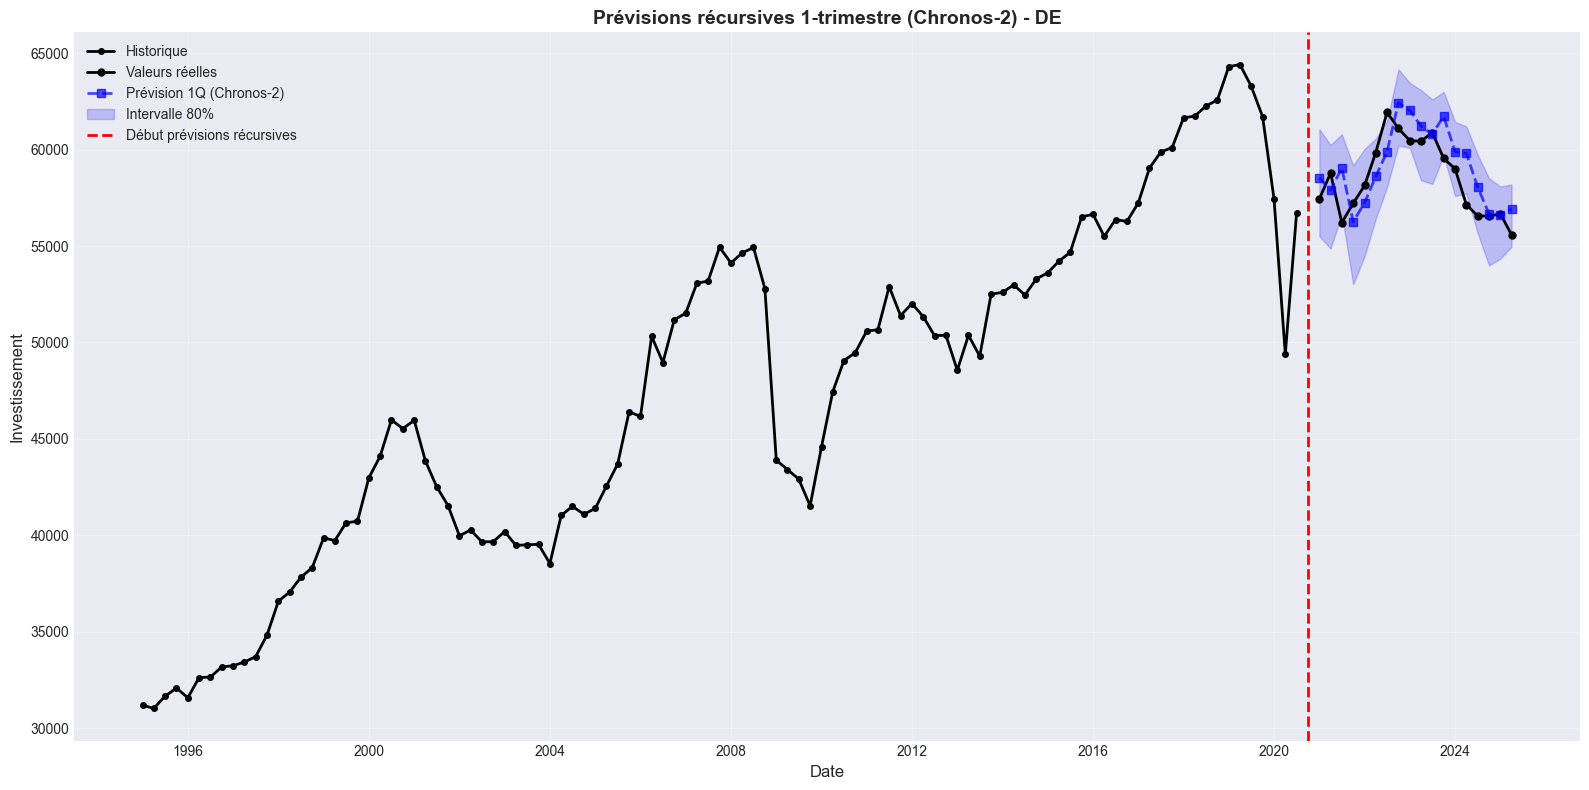

In [24]:
### 6.1. Prévisions 1 trimestre - Chronos-2

# Select only 1-quarter ahead forecasts (horizon_step == 1) for cleaner visualization
chronos_1q = recursive_chronos_forecasts[recursive_chronos_forecasts['horizon_step'] == 1].copy()

# Get the median column
median_col = [col for col in chronos_1q.columns if 'p50' in col.lower()][0]
p10_col = [col for col in chronos_1q.columns if 'p10' in col.lower()][0]
p90_col = [col for col in chronos_1q.columns if 'p90' in col.lower()][0]

# Get historical data for context
hist_data = df_full[df_full[ID_COLUMN] == RECURSIVE_COUNTRY].copy()
hist_data = hist_data[hist_data[TIMESTAMP_COLUMN] < pd.to_datetime(RECURSIVE_START_DATE)]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot historical data
ax.plot(hist_data[TIMESTAMP_COLUMN], hist_data[TARGET_COLUMN], 
        'o-', linewidth=2, markersize=4, label='Historique', color='black')

# Plot actual values in forecast period
actual_mask = chronos_1q['actual'].notna()
if actual_mask.any():
    ax.plot(chronos_1q.loc[actual_mask, TIMESTAMP_COLUMN], 
           chronos_1q.loc[actual_mask, 'actual'], 
           'o-', linewidth=2, markersize=5, label='Valeurs réelles', 
           color='black')

# Plot 1-quarter ahead forecasts
ax.plot(chronos_1q[TIMESTAMP_COLUMN], chronos_1q[median_col], 
       's--', linewidth=2, markersize=6, label='Prévision 1Q (Chronos-2)', 
       color='blue', alpha=0.7)

# Add confidence intervals
ax.fill_between(chronos_1q[TIMESTAMP_COLUMN], 
                chronos_1q[p10_col], 
                chronos_1q[p90_col],
                alpha=0.2, color='blue', label='Intervalle 80%')

ax.axvline(x=pd.to_datetime(RECURSIVE_START_DATE), color='red', 
          linestyle='--', linewidth=2, label='Début prévisions récursives')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investissement', fontsize=12)
ax.set_title(f'Prévisions récursives 1-trimestre (Chronos-2) - {RECURSIVE_COUNTRY}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


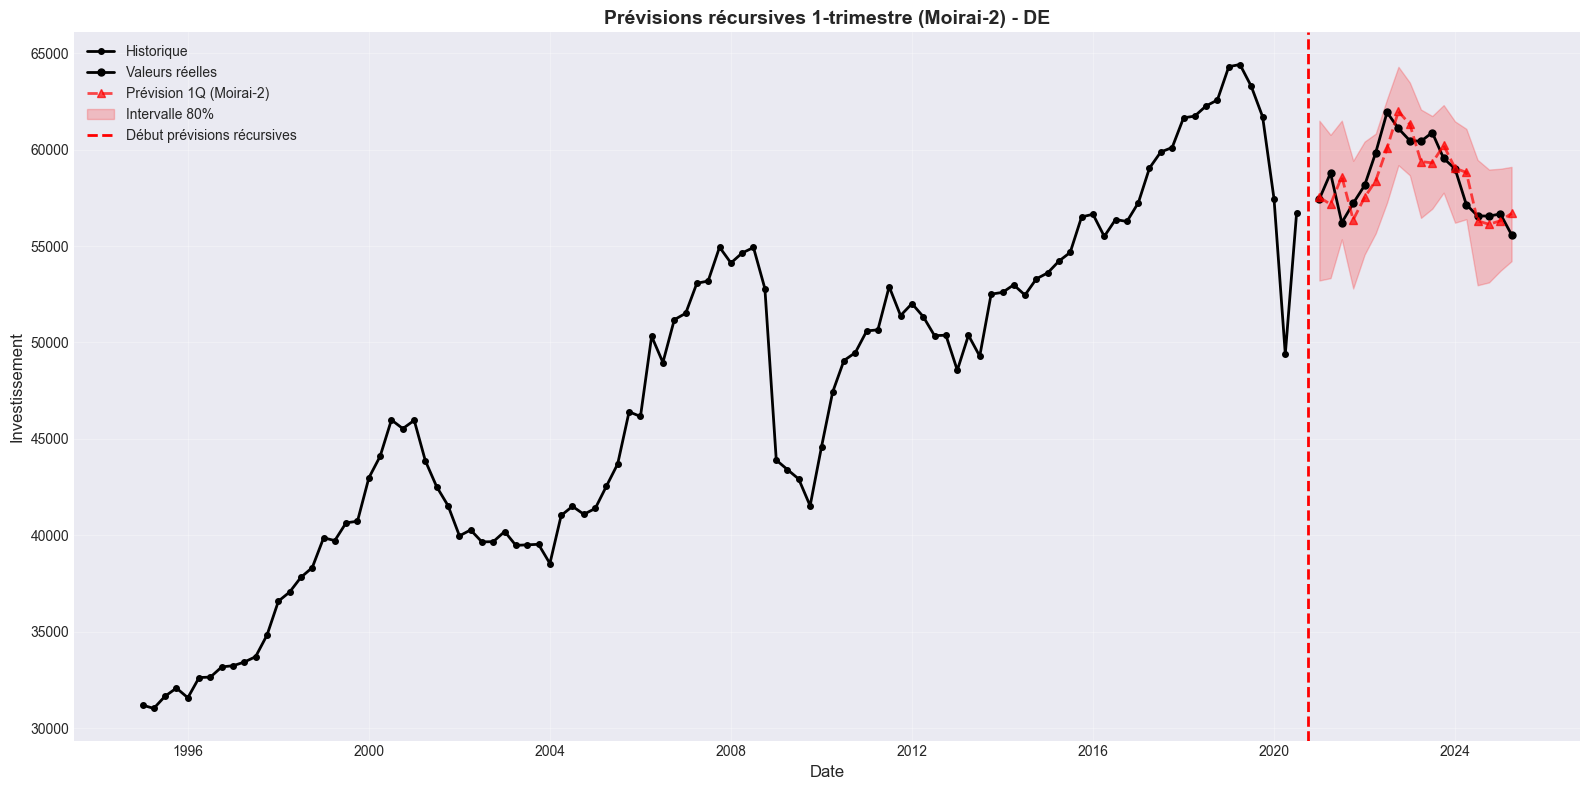

In [25]:
### 6.2. Prévisions 1 trimestre - Moirai-2

# Select only 1-quarter ahead forecasts (horizon_step == 1) for cleaner visualization
moirai_1q = recursive_moirai_forecasts[recursive_moirai_forecasts['horizon_step'] == 1].copy()

# Get the median column
median_col_m = [col for col in moirai_1q.columns if 'p50' in col.lower()][0]
p10_col_m = [col for col in moirai_1q.columns if 'p10' in col.lower()][0]
p90_col_m = [col for col in moirai_1q.columns if 'p90' in col.lower()][0]

# Get historical data for context
hist_data_m = df_full[df_full[ID_COLUMN] == RECURSIVE_COUNTRY].copy()
hist_data_m = hist_data_m[hist_data_m[TIMESTAMP_COLUMN] < pd.to_datetime(RECURSIVE_START_DATE)]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot historical data
ax.plot(hist_data_m[TIMESTAMP_COLUMN], hist_data_m[TARGET_COLUMN], 
        'o-', linewidth=2, markersize=4, label='Historique', color='black')

# Plot actual values in forecast period
actual_mask_m = moirai_1q['actual'].notna()
if actual_mask_m.any():
    ax.plot(moirai_1q.loc[actual_mask_m, TIMESTAMP_COLUMN], 
           moirai_1q.loc[actual_mask_m, 'actual'], 
           'o-', linewidth=2, markersize=5, label='Valeurs réelles', 
           color='black')

# Plot 1-quarter ahead forecasts
ax.plot(moirai_1q[TIMESTAMP_COLUMN], moirai_1q[median_col_m], 
       '^--', linewidth=2, markersize=6, label='Prévision 1Q (Moirai-2)', 
       color='red', alpha=0.7)

# Add confidence intervals
ax.fill_between(moirai_1q[TIMESTAMP_COLUMN], 
                moirai_1q[p10_col_m], 
                moirai_1q[p90_col_m],
                alpha=0.2, color='red', label='Intervalle 80%')

ax.axvline(x=pd.to_datetime(RECURSIVE_START_DATE), color='red', 
          linestyle='--', linewidth=2, label='Début prévisions récursives')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investissement', fontsize=12)
ax.set_title(f'Prévisions récursives 1-trimestre (Moirai-2) - {RECURSIVE_COUNTRY}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 6.3. Comparaison des erreurs par horizon


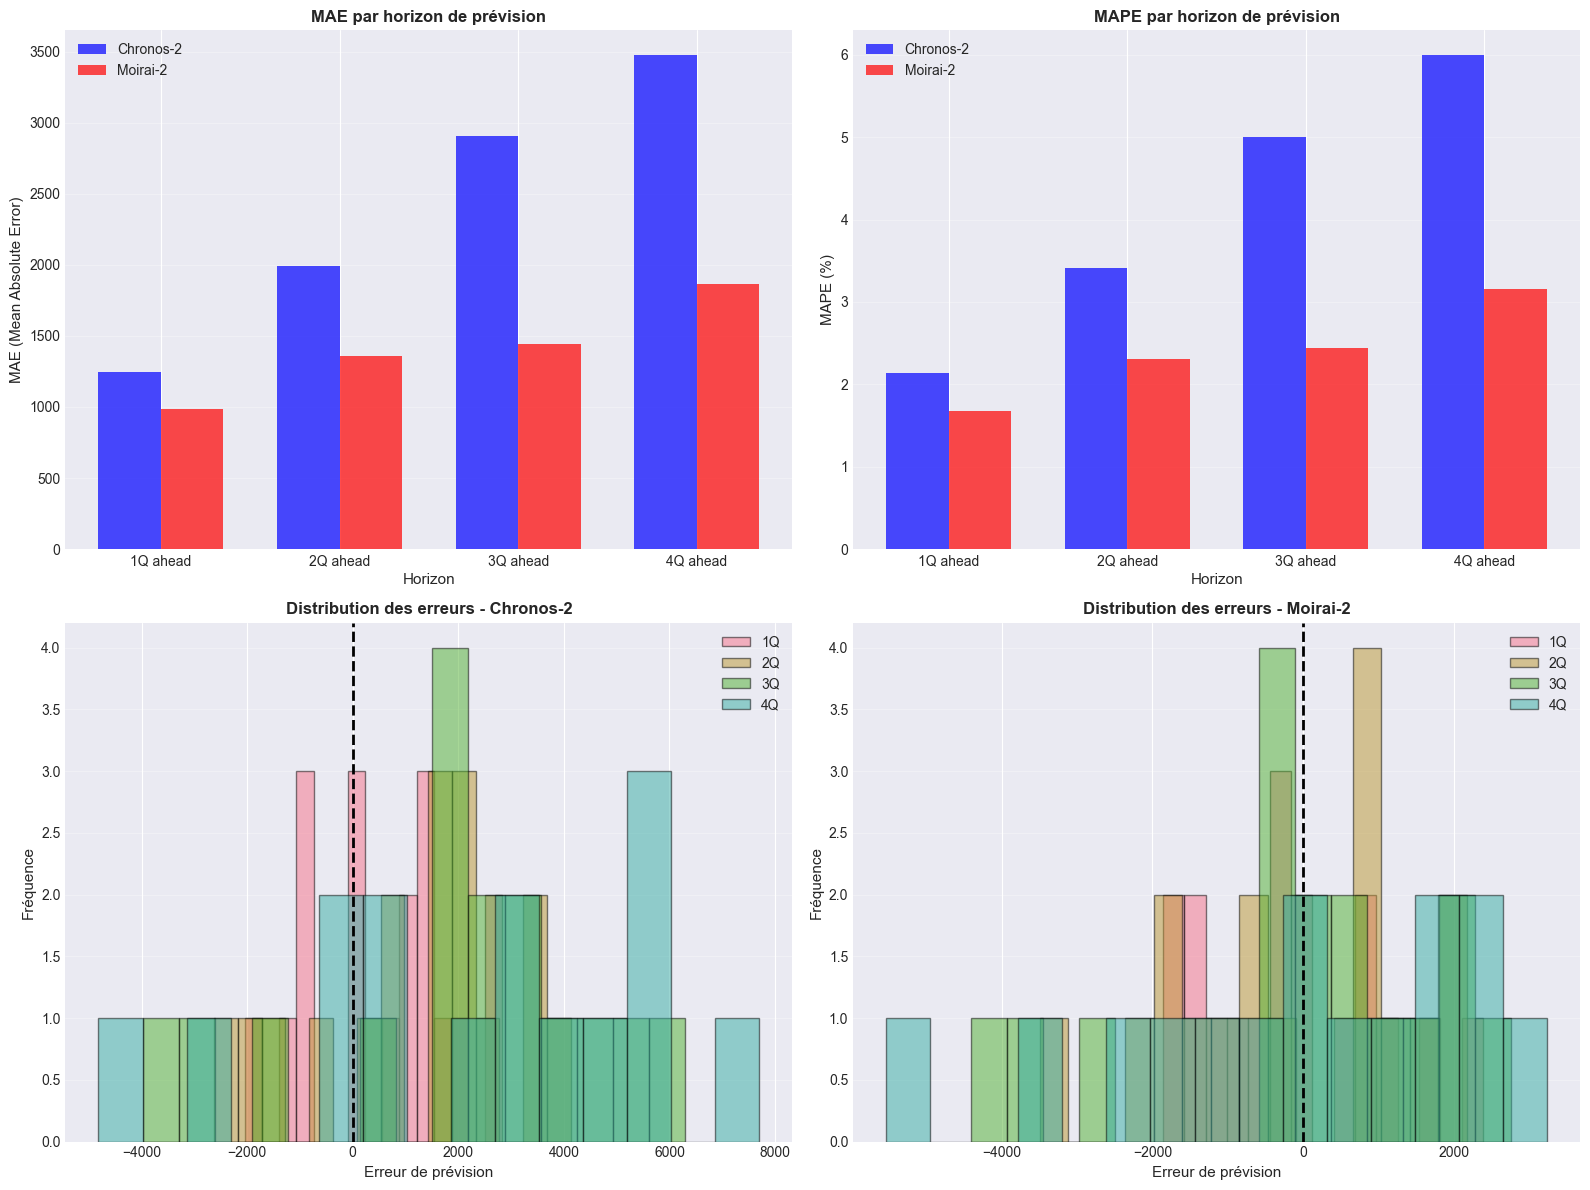

In [26]:
if chronos_with_errors is not None and moirai_with_errors is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Get median columns
    chronos_median = [col for col in chronos_with_errors.columns if 'chronos' in col.lower() and 'p50' in col.lower()][0]
    moirai_median = [col for col in moirai_with_errors.columns if 'moirai' in col.lower() and 'p50' in col.lower()][0]
    
    # 1. MAE by horizon
    ax = axes[0, 0]
    chronos_mae_by_h = chronos_by_horizon.set_index('Horizon')['MAE']
    moirai_mae_by_h = moirai_by_horizon.set_index('Horizon')['MAE']
    
    x = np.arange(len(chronos_mae_by_h))
    width = 0.35
    ax.bar(x - width/2, chronos_mae_by_h.values, width, label='Chronos-2', color='blue', alpha=0.7)
    ax.bar(x + width/2, moirai_mae_by_h.values, width, label='Moirai-2', color='red', alpha=0.7)
    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('MAE (Mean Absolute Error)', fontsize=11)
    ax.set_title('MAE par horizon de prévision', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(chronos_mae_by_h.index)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. MAPE by horizon
    ax = axes[0, 1]
    chronos_mape_by_h = chronos_by_horizon.set_index('Horizon')['MAPE']
    moirai_mape_by_h = moirai_by_horizon.set_index('Horizon')['MAPE']
    
    ax.bar(x - width/2, chronos_mape_by_h.values, width, label='Chronos-2', color='blue', alpha=0.7)
    ax.bar(x + width/2, moirai_mape_by_h.values, width, label='Moirai-2', color='red', alpha=0.7)
    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('MAPE (%)', fontsize=11)
    ax.set_title('MAPE par horizon de prévision', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(chronos_mape_by_h.index)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Error distribution for Chronos-2
    ax = axes[1, 0]
    for h in sorted(chronos_with_errors['horizon_step'].unique()):
        h_data = chronos_with_errors[chronos_with_errors['horizon_step'] == h]
        ax.hist(h_data['error'], bins=15, alpha=0.5, label=f'{h}Q', edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Erreur de prévision', fontsize=11)
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title('Distribution des erreurs - Chronos-2', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Error distribution for Moirai-2
    ax = axes[1, 1]
    for h in sorted(moirai_with_errors['horizon_step'].unique()):
        h_data = moirai_with_errors[moirai_with_errors['horizon_step'] == h]
        ax.hist(h_data['error'], bins=15, alpha=0.5, label=f'{h}Q', edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Erreur de prévision', fontsize=11)
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title('Distribution des erreurs - Moirai-2', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## 7. Analyse de convergence des prévisions

### 🎯 Objectif

Cette section évalue si **les prévisions deviennent plus précises lorsqu'on est plus proche de la date cible**.

Pour chaque date future (ex: 2022-Q1), nous avons **plusieurs prévisions** faites à différents moments:
- 4 trimestres avant (horizon 4Q)
- 3 trimestres avant (horizon 3Q)
- 2 trimestres avant (horizon 2Q)
- 1 trimestre avant (horizon 1Q)

**Question clé**: Est-ce que la prévision faite 1 trimestre avant est plus précise que celle faite 4 trimestres avant?


In [27]:
### 7.1. Tableau de convergence des erreurs

def analyze_convergence(forecasts_df, model_name):
    """Analyze how errors change as horizon decreases (getting closer to target)."""
    # Filter to only forecasts with actual values
    with_actual = forecasts_df[forecasts_df['actual'].notna()].copy()
    
    if len(with_actual) == 0:
        return None
    
    # Get median column
    median_col = [col for col in with_actual.columns if 'p50' in col.lower()][0]
    
    # Calculate errors
    with_actual['abs_error'] = np.abs(with_actual[median_col] - with_actual['actual'])
    with_actual['pct_error'] = (with_actual['abs_error'] / with_actual['actual']) * 100
    
    # Group by horizon
    convergence = with_actual.groupby('horizon_step').agg({
        'abs_error': ['mean', 'std', 'min', 'max'],
        'pct_error': ['mean', 'std'],
        'timestamp': 'count'
    }).round(2)
    
    convergence.columns = ['MAE', 'Std Error', 'Min Error', 'Max Error', 'MAPE (%)', 'Std MAPE (%)', 'N']
    convergence.index.name = 'Horizon'
    
    return convergence

print("=" * 100)
print("📊 ANALYSE DE CONVERGENCE - Comment les erreurs évoluent selon l'horizon")
print("=" * 100)

# Chronos-2
chronos_convergence = analyze_convergence(recursive_chronos_forecasts, 'Chronos-2')
if chronos_convergence is not None:
    print(f"\n🔵 CHRONOS-2 - Erreurs par horizon de prévision:")
    print("   (Horizon 1 = 1 trimestre avant la date cible, Horizon 4 = 4 trimestres avant)")
    print()
    print(chronos_convergence.to_string())
    
    # Calculate improvement from 4Q to 1Q ahead
    mae_4q = chronos_convergence.loc[4, 'MAE']
    mae_1q = chronos_convergence.loc[1, 'MAE']
    improvement = ((mae_4q - mae_1q) / mae_4q) * 100
    print(f"\n   💡 Amélioration de précision: {improvement:.1f}% entre 4Q et 1Q avant")
    print(f"      MAE passe de {mae_4q:.0f} (4Q) à {mae_1q:.0f} (1Q)")

# Moirai-2
moirai_convergence = analyze_convergence(recursive_moirai_forecasts, 'Moirai-2')
if moirai_convergence is not None:
    print(f"\n🔴 MOIRAI-2 - Erreurs par horizon de prévision:")
    print("   (Horizon 1 = 1 trimestre avant la date cible, Horizon 4 = 4 trimestres avant)")
    print()
    print(moirai_convergence.to_string())
    
    # Calculate improvement from 4Q to 1Q ahead
    mae_4q_m = moirai_convergence.loc[4, 'MAE']
    mae_1q_m = moirai_convergence.loc[1, 'MAE']
    improvement_m = ((mae_4q_m - mae_1q_m) / mae_4q_m) * 100
    print(f"\n   💡 Amélioration de précision: {improvement_m:.1f}% entre 4Q et 1Q avant")
    print(f"      MAE passe de {mae_4q_m:.0f} (4Q) à {mae_1q_m:.0f} (1Q)")

# Comparison
if chronos_convergence is not None and moirai_convergence is not None:
    print(f"\n📊 COMPARAISON:")
    print(f"\n   Prévisions à 1 trimestre (les plus récentes):")
    print(f"     Chronos-2: MAE = {chronos_convergence.loc[1, 'MAE']:.0f}, MAPE = {chronos_convergence.loc[1, 'MAPE (%)']:.2f}%")
    print(f"     Moirai-2:  MAE = {moirai_convergence.loc[1, 'MAE']:.0f}, MAPE = {moirai_convergence.loc[1, 'MAPE (%)']:.2f}%")
    
    print(f"\n   Prévisions à 4 trimestres (les plus éloignées):")
    print(f"     Chronos-2: MAE = {chronos_convergence.loc[4, 'MAE']:.0f}, MAPE = {chronos_convergence.loc[4, 'MAPE (%)']:.2f}%")
    print(f"     Moirai-2:  MAE = {moirai_convergence.loc[4, 'MAE']:.0f}, MAPE = {moirai_convergence.loc[4, 'MAPE (%)']:.2f}%")
    
    # Determine which model handles long-term better
    chronos_degradation = mae_4q / mae_1q
    moirai_degradation = mae_4q_m / mae_1q_m
    
    print(f"\n   Dégradation des prévisions à long terme:")
    print(f"     Chronos-2: MAE(4Q) / MAE(1Q) = {chronos_degradation:.2f}x")
    print(f"     Moirai-2:  MAE(4Q) / MAE(1Q) = {moirai_degradation:.2f}x")
    
    if moirai_degradation < chronos_degradation:
        print(f"\n   ✅ Moirai-2 maintient mieux sa précision sur des horizons longs")
    else:
        print(f"\n   ✅ Chronos-2 maintient mieux sa précision sur des horizons longs")

print("\n" + "=" * 100)


📊 ANALYSE DE CONVERGENCE - Comment les erreurs évoluent selon l'horizon

🔵 CHRONOS-2 - Erreurs par horizon de prévision:
   (Horizon 1 = 1 trimestre avant la date cible, Horizon 4 = 4 trimestres avant)

             MAE  Std Error  Min Error  Max Error  MAPE (%)  Std MAPE (%)   N
Horizon                                                                      
1        1249.72     801.10      57.59    2835.96      2.14          1.39  18
2        1989.90    1072.17     271.20    4129.75      3.41          1.87  17
3        2910.15    1561.92     253.83    6302.79      5.00          2.75  16
4        3476.85    2252.71      82.29    7701.18      6.00          3.99  15

   💡 Amélioration de précision: 64.1% entre 4Q et 1Q avant
      MAE passe de 3477 (4Q) à 1250 (1Q)

🔴 MOIRAI-2 - Erreurs par horizon de prévision:
   (Horizon 1 = 1 trimestre avant la date cible, Horizon 4 = 4 trimestres avant)

             MAE  Std Error  Min Error  Max Error  MAPE (%)  Std MAPE (%)   N
Horizon             

In [28]:
## 8. Sauvegarde des résultats

### 8.1. Export au format CSV

# Create output directory
output_dir = RESULTS_DIR / "recursive"
output_dir.mkdir(parents=True, exist_ok=True)

# Save Chronos-2 recursive forecasts
chronos_output = output_dir / f"recursive_chronos_{RECURSIVE_COUNTRY}_{RECURSIVE_HORIZON}q.csv"
recursive_chronos_forecasts.to_csv(chronos_output, index=False)

# Save Moirai-2 recursive forecasts
moirai_output = output_dir / f"recursive_moirai_{RECURSIVE_COUNTRY}_{RECURSIVE_HORIZON}q.csv"
recursive_moirai_forecasts.to_csv(moirai_output, index=False)

# Save metrics
if chronos_by_horizon is not None and moirai_by_horizon is not None:
    metrics_output = output_dir / f"recursive_metrics_{RECURSIVE_COUNTRY}_{RECURSIVE_HORIZON}q.csv"
    
    # Combine metrics
    chronos_by_horizon['Model'] = 'Chronos-2'
    moirai_by_horizon['Model'] = 'Moirai-2'
    combined_metrics = pd.concat([chronos_by_horizon, moirai_by_horizon], ignore_index=True)
    combined_metrics.to_csv(metrics_output, index=False)
    
    print(f"✅ Métriques sauvegardées: {metrics_output}")

print(f"✅ Prévisions récursives sauvegardées:")
print(f"  Chronos-2: {chronos_output}")
print(f"  Moirai-2: {moirai_output}")


✅ Métriques sauvegardées: /Users/matthieualcouffe/projet/ECB_Forecast/results/recursive/recursive_metrics_DE_4q.csv
✅ Prévisions récursives sauvegardées:
  Chronos-2: /Users/matthieualcouffe/projet/ECB_Forecast/results/recursive/recursive_chronos_DE_4q.csv
  Moirai-2: /Users/matthieualcouffe/projet/ECB_Forecast/results/recursive/recursive_moirai_DE_4q.csv


## 5. Recursive Forecasting Function

We'll use a simplified function that works with both base and fine-tuned models.


In [29]:
## 9. Résumé final

print("=" * 80)
print("📊 RÉSUMÉ - PRÉVISIONS RÉCURSIVES")
print("=" * 80)

print(f"\n🎯 Configuration:")
print(f"  Pays: {RECURSIVE_COUNTRY}")
print(f"  Période: {RECURSIVE_START_DATE} → {RECURSIVE_END_DATE}")
print(f"  Horizon par prévision: {RECURSIVE_HORIZON} trimestres")
print(f"  Quantiles: {QUANTILE_LEVELS}")

print(f"\n📈 Nombre total de prévisions générées:")
print(f"  Chronos-2: {len(recursive_chronos_forecasts)} prévisions")
print(f"  Moirai-2: {len(recursive_moirai_forecasts)} prévisions")

if chronos_overall and moirai_overall:
    print(f"\n🎯 Performance globale:")
    print(f"\n  Chronos-2:")
    print(f"    MAE:  {chronos_overall['MAE']:.2f}")
    print(f"    RMSE: {chronos_overall['RMSE']:.2f}")
    print(f"    MAPE: {chronos_overall['MAPE']:.2f}%")
    
    print(f"\n  Moirai-2:")
    print(f"    MAE:  {moirai_overall['MAE']:.2f}")
    print(f"    RMSE: {moirai_overall['RMSE']:.2f}")
    print(f"    MAPE: {moirai_overall['MAPE']:.2f}%")
    
    print(f"\n  🏆 Meilleur modèle:")
    if chronos_overall['MAE'] < moirai_overall['MAE']:
        improvement = ((moirai_overall['MAE'] - chronos_overall['MAE']) / moirai_overall['MAE']) * 100
        print(f"    Chronos-2 (MAE {improvement:.1f}% inférieure)")
    else:
        improvement = ((chronos_overall['MAE'] - moirai_overall['MAE']) / chronos_overall['MAE']) * 100
        print(f"    Moirai-2 (MAE {improvement:.1f}% inférieure)")

print(f"\n💾 Fichiers sauvegardés:")
print(f"  Prévisions CSV: {output_dir}/")
print(f"  Template Excel: {excel_template_path}")

print("\n✅ Analyse récursive terminée!")
print("=" * 80)


📊 RÉSUMÉ - PRÉVISIONS RÉCURSIVES

🎯 Configuration:
  Pays: DE
  Période: 2020-10-01 → 2025-01-01
  Horizon par prévision: 4 trimestres
  Quantiles: [0.1, 0.5, 0.9]

📈 Nombre total de prévisions générées:
  Chronos-2: 72 prévisions
  Moirai-2: 72 prévisions

🎯 Performance globale:

  Chronos-2:
    MAE:  2349.07
    RMSE: 2884.66
    MAPE: 4.04%

  Moirai-2:
    MAE:  1393.21
    RMSE: 1775.57
    MAPE: 2.36%

  🏆 Meilleur modèle:
    Moirai-2 (MAE 40.7% inférieure)

💾 Fichiers sauvegardés:
  Prévisions CSV: /Users/matthieualcouffe/projet/ECB_Forecast/results/recursive/
  Template Excel: /Users/matthieualcouffe/projet/ECB_Forecast/results/TeamXX_recursive_investment_predictions.xlsx

✅ Analyse récursive terminée!


## 10. Notes méthodologiques

### Principe de la prévision récursive

La **prévision récursive** (ou rolling forecast) fonctionne différemment de la prévision directe:

#### Approche directe (sections précédentes):
- Utiliser les données jusqu'à une date fixe (ex: 2020-Q4)
- Prévoir tous les futurs trimestres en une seule fois (ex: 17 trimestres)
- Génère une seule prévision par date future

#### Approche récursive (cette section):
- Pour **chaque trimestre** de la période de test:
  1. Utiliser toutes les données disponibles jusqu'à ce trimestre
  2. Prévoir les N prochains trimestres (ex: 4 trimestres)
  3. Stocker les prévisions
- Génère **plusieurs prévisions** par date future (à différents horizons)

### Exemple concret

Pour prévoir 2022-Q1 avec un horizon de 4 trimestres:

| Origine | Données jusqu'à | Horizon | Prévision pour 2022-Q1 |
|---------|----------------|---------|------------------------|
| 2020-Q4 | 2020-Q4 | 4Q | Prévision 1 |
| 2021-Q1 | 2021-Q1 | 3Q | Prévision 2 |
| 2021-Q2 | 2021-Q2 | 2Q | Prévision 3 |
| 2021-Q3 | 2021-Q3 | 1Q | Prévision 4 |

Résultat: 4 prévisions différentes pour 2022-Q1, chacune avec un horizon différent.

### Avantages de cette approche

1. **Évaluation plus réaliste**: Simule comment le modèle serait utilisé en production
2. **Analyse par horizon**: Permet de voir si les prévisions à court terme sont plus précises
3. **Robustesse**: Teste le modèle avec différentes quantités de données historiques
4. **Détection de tendances**: Montre comment les prévisions évoluent au fil du temps

### Métriques calculées

- **Par horizon**: MAE, RMSE, MAPE pour 1Q, 2Q, 3Q, 4Q
- **Globales**: Moyennes sur tous les horizons et toutes les dates
- **Distribution des erreurs**: Analyse de la cohérence des prévisions

### Format du fichier Excel

Le fichier Excel généré suit le format du template ECB avec:
- **cutoff**: Date de coupure (jusqu'à quelle date les données d'entraînement sont utilisées)
- **oos_date**: Date de prévision (out-of-sample)
- **y_true**: Valeur réelle si disponible
- **y_pred**: Valeur prédite (médiane)
- **quantile_0.1 à quantile_0.9**: Intervalles de prédiction

Les quantiles intermédiaires (0.2, 0.3, 0.4, 0.6, 0.7, 0.8) sont interpolés linéairement à partir des quantiles disponibles (0.1, 0.5, 0.9).
